In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
delta=5
def gausin_distance(x,y,delta=delta):
    H= torch.norm(x-y).cuda()
    distance = torch.exp(-H/2/(delta**2)).cuda()
    
    return distance
def gram_matrix(data,kernel=gausin_distance):
    #num=data.shape[0]
    #matrix=torch.zeros((num,num)).cuda()
    #for i in range (0,num):
    #   for j in range (0,num):
    #        matrix[i][j]=kernel(data[i],data[j])
    num=data.shape[0]
    datav3=torch.mm(data,torch.transpose(data, 0, 1).cuda()).cuda()
    datav1=torch.diag(datav3,0).cuda()
    #print(datav1.shape)
    #matrix=torch.sqrt(datav1+datav2-2*datav3)
    buf1=((-2)*datav3+datav1).cuda()
    buf2=torch.transpose(buf1, 0, 1).cuda()
    buf3=(buf2+datav1).cuda()
    #print(buf3)
    matrix = torch.exp(-buf3/2/(delta**2)).cuda()
    return matrix
def emerinal_hsic(X,Y):
    num=X.shape[0]
    #print(num)
    
    
    
    Kx=gram_matrix(X)
    
    Ky=gram_matrix(Y)
    
    H = torch.eye(num).cuda() - torch.ones((num,num), dtype = torch.float32).cuda() / num
    #print(H)
    hsic=1/(num-1)*torch.trace(torch.mm(torch.mm(torch.mm(Kx,H).cuda(),Ky).cuda(),H).cuda()).cuda()
    
    return hsic
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torchvision.datasets
from PIL import Image
batch_size=256
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,download=False):
        
        super(MyMNIST,self).__init__(root, train, transform, target_transform,download)
        #print(self.data)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])
        #print(target) 
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        else:
            target=torch.as_tensor(target)
            target = F.one_hot(target,num_classes=10).cuda()

        return img, target
mnist_data=torchvision.datasets.MNIST(root='./MNIST/', train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
#D_in, H1,H2,H3,H4,H5,H6,H7, D_out = 784, 64,32,16,8,4,2,1,10
layer_num=[784,64]
costs=[]
dtype=torch.float
continue_flag=1
PATH='./checkpoint_cnn_multilayer'
w=[]
z=[]
rate_list=[]
if continue_flag:
    
    checkpoint = torch.load(PATH)
    
    w=checkpoint['w']

else:
    for i in range(len(layer_num)-1):
    
        
        m = torch.nn.Conv2d(1, 32, 3, stride=1,padding=2).cuda()
        w.append(m)
        m=torch.nn.Conv2d(32, 64, 3, stride=1,padding=2).cuda()
        w.append(m)
        m=torch.nn.Conv2d(64, 3, 3, stride=1,padding=2).cuda()
        w.append(m)
        m=torch.nn.Conv2d(3, 1, 3, stride=1,padding=0).cuda()
        w.append(m)


epoches=20
lamda=20
learning_rate=0
data_tsne_label=[]
data_tsne_rp1=[]
data_tsne_rp2=[]
for i in range(epoches): 
    for i_batch, (img,target) in enumerate(data_loader):
        z=[]
        costs=[]
        informs=[]
        entropys=[]
        img=img.reshape(-1,1,28,28).cuda()
        
        target=torch.as_tensor(target).cuda()
        num=target.shape[0]
        #print(num)
        target=target.reshape(num,1).cuda()
        #target = F.one_hot(target,num_classes=10).cuda()
        target=torch.zeros((num,10)).cuda().scatter_(1,target,1).cuda()
        
        target=torch.as_tensor(target,dtype=dtype).cuda()
        
        z.append(F.relu(F.max_pool2d(w[0](img), 2)).cuda())
        #print(z[0].shape)
        #for cnt in range(len(w)-1):
            
        #   z.append(torch.tanh(torch.mm(z[cnt],w[cnt+1]).cuda()).cuda())
        z.append(F.relu(F.max_pool2d(w[1](z[0]), 2)).cuda())
       # print(z[1].shape)
        z.append(F.relu(F.max_pool2d(w[2](z[1]), 2)).cuda())
       # print(z[2].shape)
        z.append(F.relu(F.max_pool2d(w[3](z[2]), 2)).cuda())
       # print(z[3].shape)
        #print(z[1].shape)
        
        grad_list=[]
        
        for cnt in range(len(z)-1):
            information=-lamda*emerinal_hsic(z[cnt].view(img.shape[0],-1).cuda(),target)
            entropy=emerinal_hsic(z[cnt].view(img.shape[0],-1).cuda(),img.view(-1,784).cuda())
            #
            #z[cnt-1].view(img.shape[0],-1).cuda()
            cost=-entropy
            informs.append(information)
            entropys.append(entropy)
            costs.append(cost)
            
        #print(cost1)
        #    cost.backward(retain_graph=True)
        #    print('!')
        #print(w1.cuda().grad)
        #   with torch.no_grad():
        #        buf=torch.zeros((w[cnt].shape)).cuda()
                #print(buf.shape)
        #       buf.copy_(w[cnt].grad)
                
        #        grad_list.append(buf)
            #print('grad1',torch.norm(grad1))
            #w2 -= learning_rate * w2.grad

            # Manually zero the gradients after updating weights
        #        w[cnt].grad.zero_()
                #print(cnt,torch.norm(buf))
            #w2.grad.zero_()
        z[-1]=z[-1].view(img.shape[0],-1).cuda()
        #print(z[-1].shape)
        img=img.view(img.shape[0],-1).cuda()
        entropy=emerinal_hsic(z[-1],img)
        #z[-2].view(img.shape[0],-1).cuda()
        information=lamda*emerinal_hsic(z[-1],target)
        rate=entropy/information
        #cost=-entropy-information+0.01*(entropy/information)
        cost=-entropy
        costs.append(cost)
        entropys.append(entropy)
        informs.append(information)
        cost.backward()
        
        with torch.no_grad():
            #w1 -= learning_rate * w1.grad
            #print('grad2',torch.norm(w2.grad))
            w[-1].weight -= learning_rate * w[-1].weight.grad
            
            
            w[0].weight -= learning_rate * w[0].weight.grad
            w[1].weight -= learning_rate * w[1].weight.grad
            w[2].weight -= learning_rate * w[2].weight.grad
            
        # Manually zero the gradients after updating weights
            w[-1].weight.grad.zero_()
            w[0].weight.grad.zero_()
            w[1].weight.grad.zero_()
            w[2].weight.grad.zero_()
        #    data_tsne_rp2.append(z2.cpu().data.numpy())
        #    data_tsne_rp1.append(z1.cpu().data.numpy())
        #    data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
        

        if i_batch %100 ==0:
            
            print(rate)
            rate_list.append(rate)
            print(i_batch)
            print('costs',costs)
            print('entropys',entropys)
            print('informs',informs)
            print('entr',entropy)
            print('inf',information)
            data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
            torch.save({
            'w': w,
            'z': z,
            'data_tsne_label':target.argmax(dim=1, keepdim=True).cpu().data.numpy()
            ,'costs':costs
            #'data_tsne_rp2':data_tsne_rp2,
            #'data_tsne_rp1':data_tsne_rp1
                
            }, PATH)
            
            data_tsne_label=[]
            #data_tsne_rp1=[]
            #data_tsne_rp2=[]

            #for j,zz in enumerate(z2):
                #print(j,zz)
                #print(j,target[j])
            
plt.plot(rate_list)
plt.ylabel('rate')
plt.xlabel('epochs (per 1)')
plt.title("Learning rate = " + str(learning_rate))
plt.show()

In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
%pylab inline
import numpy as np
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    print(len(labels))
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)
    
plt.ion()
PATH='./checkpoint_cnn_multilayer2'
checkpoint = torch.load(PATH)
data_tsne_label=np.array(checkpoint['data_tsne_label'])
data_tsne_rp=np.array(checkpoint['z'][-4].view(data_tsne_label.shape[0],-1).cpu().data.numpy())
#print(data_tsne_rp.shape)
#print(data_tsne_rp[:50,:],data_tsne_label[:50])
#for j in range(256):
#    sums=0
#    if data_tsne_label[j]==1:
#        for i in range((data_tsne_rp.shape[1])):
#            if data_tsne_rp[j][i]>=0:
#                x=1
#            else:
#                x=0
#            sums+=x*np.power(0.2,i)
#        print(sums)
#print()
'''
pic={'0':[],'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[],'8':[],'9':[]}
print(pic)
for i in range(10):
    print('!!!!')
    for j in range(256):
        if data_tsne_label[j]==i:
           # print(i,str(i))
           # pic[str(i)].append(data_tsne_rp[j])
           # print(data_tsne_label[j])
           print(data_tsne_rp[j])
data_tsne_label=data_tsne_label.reshape((-1))
'''
#plt.hist(data_tsne_rp[:256], bins=200, range=(20,150),histtype="stepfilled", alpha=.8)

#print(np.histogram(data_tsne_rp[:200],bins=100,range=(0,100)))
#for i in range(10):
    #plt.hist(pic[str(i)], bins=100, range=(0,100),normed=True,histtype="stepfilled", alpha=.8)
    #print('!!!')
    #print(pic[str(i)])
#print(data_tsne_label)
#data_tsne=np.array(data_tsne[:][])

Populating the interactive namespace from numpy and matplotlib


"\npic={'0':[],'1':[],'2':[],'3':[],'4':[],'5':[],'6':[],'7':[],'8':[],'9':[]}\nprint(pic)\nfor i in range(10):\n    print('!!!!')\n    for j in range(256):\n        if data_tsne_label[j]==i:\n           # print(i,str(i))\n           # pic[str(i)].append(data_tsne_rp[j])\n           # print(data_tsne_label[j])\n           print(data_tsne_rp[j])\ndata_tsne_label=data_tsne_label.reshape((-1))\n"

255


/usr/local/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


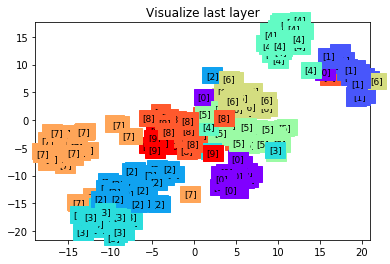

In [4]:
if HAS_SK:
    # Visualization of trained flatten layer (T-SNE)
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 255
    
    low_dim_embs = tsne.fit_transform(data_tsne_rp[:plot_only,:])
    labels = data_tsne_label[:plot_only]
    fig = plt.gcf()
    plot_with_labels(low_dim_embs, labels)
    
    
    fig.savefig('./checkpoint_cnn_multilayer2_layer_-2.png')
plt.ioff()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
delta=5
def gausin_distance(x,y,delta=delta):
    H= torch.norm(x-y).cuda()
    distance = torch.exp(-H/2/(delta**2)).cuda()
    
    return distance
def gram_matrix(data,kernel=gausin_distance):
    #num=data.shape[0]
    #matrix=torch.zeros((num,num)).cuda()
    #for i in range (0,num):
    #   for j in range (0,num):
    #        matrix[i][j]=kernel(data[i],data[j])
    num=data.shape[0]
    datav3=torch.mm(data,torch.transpose(data, 0, 1).cuda()).cuda()
    datav1=torch.diag(datav3,0).cuda()
    #print(datav1.shape)
    #matrix=torch.sqrt(datav1+datav2-2*datav3)
    buf1=((-2)*datav3+datav1).cuda()
    buf2=torch.transpose(buf1, 0, 1).cuda()
    buf3=(buf2+datav1).cuda()
    #print(buf3)
    matrix = torch.exp(-buf3/2/(delta**2)).cuda()
    return matrix
def emerinal_hsic(X,Y):
    num=X.shape[0]
    #print(num)
    
    
    
    Kx=gram_matrix(X)
    
    Ky=gram_matrix(Y)
    
    H = torch.eye(num).cuda() - torch.ones((num,num), dtype = torch.float32).cuda() / num
    #print(H)
    hsic=1/(num-1)*torch.trace(torch.mm(torch.mm(torch.mm(Kx,H).cuda(),Ky).cuda(),H).cuda()).cuda()
    
    return hsic
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torchvision.datasets
from PIL import Image
batch_size=256
class MyMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,download=False):
        
        super(MyMNIST,self).__init__(root, train, transform, target_transform,download)
        #print(self.data)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])
        #print(target) 
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        else:
            target=torch.as_tensor(target)
            target = F.one_hot(target,num_classes=10).cuda()

        return img, target
mnist_data=torchvision.datasets.MNIST(root='./MNIST/', train=True, transform=transforms.ToTensor(), target_transform=None, download=False)
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
#D_in, H1,H2,H3,H4,H5,H6,H7, D_out = 784, 64,32,16,8,4,2,1,10
layer_num=[784,64]
costs=[]
dtype=torch.float
continue_flag=1
PATH='./checkpoint_cnn_multilayer2'
w=[]
z=[]
rate_list=[]
if continue_flag:
    
    checkpoint = torch.load(PATH)
    
    w=checkpoint['w']

else:
    for i in range(len(layer_num)-1):
    
        
        m = torch.nn.Conv2d(1, 32, 3, stride=1,padding=2).cuda()
        w.append(m)
        m=torch.nn.Conv2d(32, 64, 3, stride=1,padding=2).cuda()
        w.append(m)
        m=torch.nn.Conv2d(64, 32, 3, stride=1,padding=2).cuda()
        w.append(m)
        m=torch.nn.Conv2d(32, 16, 3, stride=1,padding=2).cuda()
        w.append(m)
        m=torch.nn.Conv2d(16, 3, 3, stride=1,padding=2).cuda()
        w.append(m)
        m=torch.nn.Conv2d(3, 1, 2, stride=1,padding=0).cuda()
        w.append(m)
        

epoches=20
lamda=20
#5000
learning_rate=0
learning_rate_post=0.01
data_tsne_label=[]
data_tsne_rp1=[]
data_tsne_rp2=[]
linear=torch.nn.Linear(144,1).cuda()
for i in range(epoches): 
    for i_batch, (img,target) in enumerate(data_loader):
        z=[]
        costs=[]
        img=img.reshape(-1,1,28,28).cuda()
        
        target=torch.as_tensor(target).cuda()
        num=target.shape[0]
        #print(num)
        target=target.reshape(num,1).cuda()
        #target = F.one_hot(target,num_classes=10).cuda()
        target=torch.zeros((num,10)).cuda().scatter_(1,target,1).cuda()
        
        target=torch.as_tensor(target,dtype=dtype).cuda()
        
        z.append(F.relu(F.max_pool2d(w[0](img), 2)).cuda())
        #print(z[0].shape)
        #for cnt in range(len(w)-1):
            
        #   z.append(torch.tanh(torch.mm(z[cnt],w[cnt+1]).cuda()).cuda())
        z.append(F.relu(F.max_pool2d(w[1](z[0]), 2)).cuda())
        #print(z[1].shape)
        z.append(F.relu(F.max_pool2d(w[2](z[1]), 2)).cuda())
        #print(z[2].shape)
        z.append(F.relu(F.max_pool2d(w[3](z[2]), 2)).cuda())
        #print(z[3].shape)
        z.append(F.relu(F.max_pool2d(w[4](z[3]), 2)).cuda())
        #print(z[4].shape)
        z.append(F.relu(F.max_pool2d(w[5](z[4]), 2)).cuda())
        #print(z[5].shape)
        entropys=[]
        informs=[]
        infsums=[]
        #print(z[1].shape)
        h=z[3].view(img.shape[0],-1).cuda()
        post=linear(h)
        
        #print(h[:,1].shape)
        information=lamda*emerinal_hsic(h.view(img.shape[0],-1).cuda(),target)
        entropy=emerinal_hsic(h.view(img.shape[0],-1).cuda(),img.view(-1,784).cuda())
        
        back_inform=-lamda*emerinal_hsic(post.view(img.shape[0],-1).cuda(),target)
        
        cost=0
        number=0
        for i in range(h.shape[1]):
            cost=cost-lamda*emerinal_hsic(h[:,i].view(-1,1),target)
            xnova=lamda*emerinal_hsic(h[:,i].view(-1,1),target)
            #if xnova > 3:
                #print(i)
        #print('!!!!!')
        #print(lamda*emerinal_hsic(h.view(256,-1),target))
        infsum=cost
        cost=cost+information
        entropys.append(entropy)
        informs.append(information)
        infsums.append(infsum)
        
        costs.append(cost)
        
        grad_list=[]
        
        for cnt in range(len(z)-1):
            information=-lamda*emerinal_hsic(z[cnt].view(img.shape[0],-1).cuda(),target)
            entropy=emerinal_hsic(z[cnt].view(img.shape[0],-1).cuda(),img.view(-1,784).cuda())
            cost=-information
            costs.append(cost)
        #print(cost1)
        #    cost.backward(retain_graph=True)
        #    print('!')
        #print(w1.cuda().grad)
        #   with torch.no_grad():
        #        buf=torch.zeros((w[cnt].shape)).cuda()
                #print(buf.shape)
        #       buf.copy_(w[cnt].grad)
                
        #        grad_list.append(buf)
            #print('grad1',torch.norm(grad1))
            #w2 -= learning_rate * w2.grad

            # Manually zero the gradients after updating weights
        #        w[cnt].grad.zero_()
                #print(cnt,torch.norm(buf))
            #w2.grad.zero_()
        z[-1]=z[-1].view(img.shape[0],-1).cuda()
        #print(z[-1].shape)
        img=img.view(img.shape[0],-1).cuda()
        entropy=emerinal_hsic(z[-1],img)
        information=lamda*emerinal_hsic(z[-1],target)
        rate=entropy/information
        cost=-information
        costs.append(cost)
        #+0.00005*(entropy/information)
        #cost.backward()
        back_inform.backward()
        with torch.no_grad():
            #w1 -= learning_rate * w1.grad
            #print('grad2',torch.norm(w2.grad))
            #w[-1].weight -= learning_rate * w[-1].weight.grad
            
            
            #w[0].weight -= learning_rate * w[0].weight.grad
            #w[1].weight -= learning_rate * w[1].weight.grad
            #w[2].weight -= learning_rate * w[2].weight.grad
            #w[3].weight -= learning_rate * w[3].weight.grad
            #w[4].weight -= learning_rate * w[4].weight.grad
            linear.weight -=learning_rate_post*linear.weight.grad
            linear.bias -=learning_rate_post*linear.bias.grad
        # Manually zero the gradients after updating weights
            #w[-1].weight.grad.zero_()
            #w[0].weight.grad.zero_()
            #w[1].weight.grad.zero_()
            #w[2].weight.grad.zero_()
            #w[3].weight.grad.zero_()
            #w[4].weight.grad.zero_()
            linear.weight.grad.zero_()
            linear.bias.grad.zero_()
        #    data_tsne_rp2.append(z2.cpu().data.numpy())
        #    data_tsne_rp1.append(z1.cpu().data.numpy())
        #    data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
        

        if i_batch %100 ==0:
            #costs.append(cost)
            print('back_inform',back_inform)
            print(rate)
            rate_list.append(rate)
            print(i_batch)
            print('entroys',entropys)
            print('informs',informs)
            print('costs',costs)
            print('entr',entropy)
            print('inf',information)
            print('infsums',infsums)
            data_tsne_label.append(target.argmax(dim=1, keepdim=True).cpu().data.numpy())
            torch.save({
            'w': w,
            'z': z,
            'data_tsne_label':target.argmax(dim=1, keepdim=True).cpu().data.numpy()
            ,'costs':costs
            #'data_tsne_rp2':data_tsne_rp2,
            #'data_tsne_rp1':data_tsne_rp1
                
            }, PATH)
            
            data_tsne_label=[]
            #data_tsne_rp1=[]
            #data_tsne_rp2=[]

            #for j,zz in enumerate(z2):
                #print(j,zz)
                #print(j,target[j])
            
plt.plot(rate_list)
plt.ylabel('rate')
plt.xlabel('epochs (per 1)')
plt.title("Learning rate = " + str(learning_rate))
plt.show()

Populating the interactive namespace from numpy and matplotlib
back_inform tensor(-0.0443, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1629, device='cuda:0', grad_fn=<DivBackward0>)
0
entroys [tensor(1.0168, device='cuda:0', grad_fn=<MulBackward0>)]
informs [tensor(1.3647, device='cuda:0', grad_fn=<MulBackward0>)]
costs [tensor(-75.1017, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.8131, device='cuda:0', grad_fn=<NegBackward>), tensor(0.7262, device='cuda:0', grad_fn=<NegBackward>), tensor(0.9025, device='cuda:0', grad_fn=<NegBackward>), tensor(1.3647, device='cuda:0', grad_fn=<NegBackward>), tensor(13.9892, device='cuda:0', grad_fn=<NegBackward>), tensor(-16.5019, device='cuda:0', grad_fn=<NegBackward>)]
entr tensor(2.6880, device='cuda:0', grad_fn=<MulBackward0>)
inf tensor(16.5019, device='cuda:0', grad_fn=<MulBackward0>)
infsums [tensor(-76.4664, device='cuda:0', grad_fn=<SubBackward0>)]
back_inform tensor(-13.3667, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.1497

KeyboardInterrupt: 